In [1]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # for plot styling


In [2]:
df = pd.read_csv("data/trip.csv", index_col=0)

In [3]:
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')
# we only take start hour as start_hour + duration -> end_hour 
df["start_hour"] = df.start_time.dt.hour

In [4]:
trip_data = df.drop(columns=["bike_id", "day", "start_time", "end_time","hour", "rain_flag", "start_h3", "end_h3"])


In [5]:
trip_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 444854 entries, 0 to 567438
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   start_lng    444854 non-null  float64
 1   start_lat    444854 non-null  float64
 2   end_lng      444854 non-null  float64
 3   end_lat      444854 non-null  float64
 4   distance     444854 non-null  float64
 5   month        444854 non-null  int64  
 6   weekday      444854 non-null  int64  
 7   dayofyear    444854 non-null  int64  
 8   duration     444854 non-null  float64
 9   temperature  444854 non-null  float64
 10  wind         444854 non-null  float64
 11  rain         444854 non-null  float64
 12  sun          444854 non-null  float64
 13  start_hour   444854 non-null  int64  
dtypes: float64(10), int64(4)
memory usage: 50.9 MB


In [6]:
scaler = StandardScaler().fit(trip_data)
trip_data_scaled = scaler.transform(trip_data)


# Determine an appropriate number for clusters

In [7]:
from sklearn.decomposition import PCA


In [8]:
# Run PCA to reduce dimensionality
pca = PCA(n_components=11)
trip_data_scaled_pca = pca.fit_transform(trip_data_scaled)


In [9]:
# 95% variance explained target
sum(pca.explained_variance_ratio_)


0.9440449791717128

## We run k-means and plot our loss for different number of clusters

100%|██████████| 20/20 [03:55<00:00, 11.78s/it]


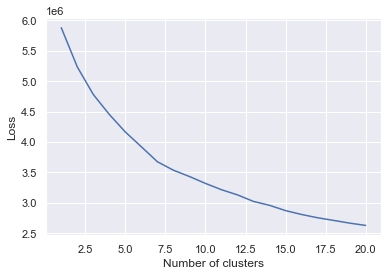

In [10]:
clusters = []
losses = []
k_max = 20

for i in tqdm(range(k_max)):
    model = KMeans(n_clusters=i+1, init="k-means++")
    model.fit(trip_data_scaled_pca)
    clusters.append(i+1)
    losses.append(model.inertia_)

plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()


(0.0, 15.0)

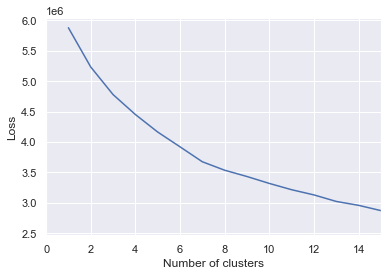

In [11]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0, 15])


### We go with 6 as our number of clusters for our soft clustering

In [12]:
gmm = GaussianMixture(n_components=6, random_state=111).fit(
    trip_data_scaled_pca)


In [13]:
labels = gmm.predict(trip_data_scaled_pca)


In [14]:
label_distribution = gmm.predict_proba(trip_data_scaled_pca)

trip_data["label_probability"] = label_distribution.max(1)

In [15]:
trip_data["labels"] = labels
df["labels"] = labels

## hot spots for vehicle availability and demand

### end points of rides

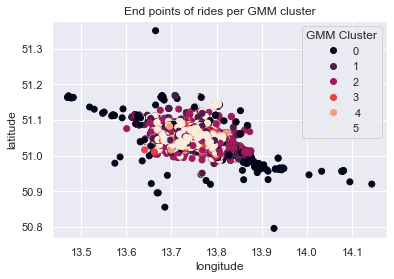

In [16]:
scatter_gmm = plt.scatter(trip_data.end_lng.to_numpy(
), trip_data.end_lat.to_numpy(), c=trip_data.labels.to_numpy())
plt.legend(handles=scatter_gmm.legend_elements()[
           0], labels=["0", "1", "2", "3", " 4", "5"], title="GMM Cluster")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("End points of rides per GMM cluster")
plt.show()


### start points of rides 


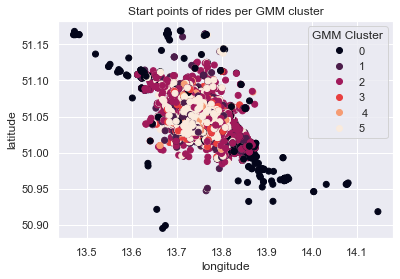

In [17]:
scatter_gmm = plt.scatter(
    trip_data.start_lng, trip_data.start_lat, c=trip_data.labels.to_numpy())
plt.legend(handles=scatter_gmm.legend_elements()[
           0], labels=["0", "1", "2", "3", " 4", "5"], title="GMM Cluster")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Start points of rides per GMM cluster")
plt.show()


## Cluster analysis

## Description of the subsequent table for Soft Clustering
After conducting a Soft Clustering with six clusters, the following aspects are notable on a broader level:
1. Start Longitude and Latitude (~13.74,~51.04, and End Longitude and Latitude (~13.74,~51.04) are in particular for all clusters equivalent except minor deviations. The Longitude and Latitude are for all clusters equivalent because our data only contains data points within Dresden.

The distinguishing features of each cluster will now be discussed. :
1. The bikes are typically rented on Wednesdays and Thursdays. In terms of the weekday feature, all clusters appear to be similar.
2. Regarding duration, Cluster 3 has the shortest trip, lasting 8 minutes, and Cluster 5 has the longest journey, lasting on average 198 minutes, or approximately 3.33 hours. Cluster 4 clients have the second-longest trips, averaging 33 minutes, followed by Cluster 1 with 14 minutes and Cluster 2 with 10 minutes.
3. It is noticeable that for Cluster 4,5, the temperature is the highest in comparison to the other clusters. At the same time, the trips tend to be slightly longer (i.e. Cluster 4,5), which might indicate a correlation between temperature and trip duration. Clusters 2,3, for example, are colder (i.e. 10 degrees Celsius to 14 degrees Celsius). Cluster 3 shows an exception by having the shortest trip duration but being as warm as clusters 4 & 5.
4. The feature start hour, which ranges from 11 a.m. to 14 a.m., does not add value to the analysis.
5. In terms of distance, it's worth noting that clusters 1 and 2, with durations of 10 and 14 minutes, have clients who drove an equal distance. Furthermore, when compared to other clusters, clients in cluster 4 drive the longest distance. Cluster 3 has the shortest duration and distance.

Cluster 0 - 3 are similar when it comes to the duration and distance. The customers in these clusters are probably spontaneous riders that rent a bike to get from one place to another. 
In cluster 4, we have a duration of 33 minutes and a distance of 2.53, indicating that this type of customer drives a long distance within about half an hour. This type of client is probably a commuter renting a bike at the railway station to get to work or from work to the railway station.

In general, it can be stated that Cluster 5 has customers who rent the bike for an extended period and travel long distances overall; however, when comparing it with cluster 4, it is evident that the duration/distance ratio for cluster 5 is low. These are tourists that rent a bike over a longer period and make multiple stops to enter tourist attractions or eat.



In [18]:
soft_cluster_analysis = df.groupby("labels").mean(
)[["start_lng", "start_lat", "end_lng", "end_lat", "weekday", "duration", "temperature", "start_hour", "distance"]]
soft_cluster_analysis


start_lng  start_lat    end_lng    end_lat   weekday    duration  \
labels                                                                     
0       13.746843  51.048059  13.745687  51.048224  3.170345  192.881045   
1       13.739791  51.045896  13.740798  51.046651  2.738243    8.515862   
2       13.744412  51.047878  13.743836  51.047764  2.943088   46.066867   
3       13.739555  51.046099  13.739915  51.046923  2.790364   12.353192   
4       13.740206  51.047264  13.740189  51.047233  2.686107   11.830312   
5       13.740623  51.048636  13.740502  51.048261  2.950766   11.988490   

        temperature  start_hour  distance  
labels                                     
0         15.736212   10.870430  1.939293  
1         18.495058   12.120127  0.955959  
2         17.583958   12.855007  2.268408  
3         17.993507   11.707878  1.734463  
4         10.685307   13.339932  1.470644  
5         10.805197   14.684312  1.541772

# Hard Clustering

In [19]:
kmns = KMeans(n_clusters=6, init="k-means++",
              random_state=1707).fit(trip_data_scaled_pca)
labels = kmns.predict(trip_data_scaled_pca)
trip_data["KM_labels"] = labels


### Test Label Overlap

In [20]:
dfPlot = pd.DataFrame()
trip_data = trip_data[trip_data["label_probability"] > 0.9]
for lbl in trip_data["labels"].unique():
    # dfPlot[lbl]=trip_data[trip_data["labels"]==lbl][["KM_labels"]].value_counts()
    t = trip_data[trip_data["labels"] == lbl][[
        "KM_labels"]].value_counts().reset_index(level=[0])
    for x in range(len(trip_data["KM_labels"].unique())):
        if x in t["KM_labels"].values:
            continue
        else:
            t.loc[len(t)] = [x, 0]
    t = t.sort_values("KM_labels")
    t.index = range(len(trip_data["KM_labels"].unique()))
    dfPlot[lbl] = t[0]


In [21]:
dfPlot = dfPlot[range(len(trip_data["labels"].unique()))]
dfPlot.index = range(len(trip_data["labels"].unique()))
dfPlot


0      1      2      3      4      5
0  5814      0    585      0      0      0
1   771  34394  20069  14373   1137  13803
2  1151  17327  15079   8124   2736  32083
3   870   9720  14271   4583   1429  13032
4  1098      0   5553  19663  10477  48833
5   948  13070   9535      0   5005  42686

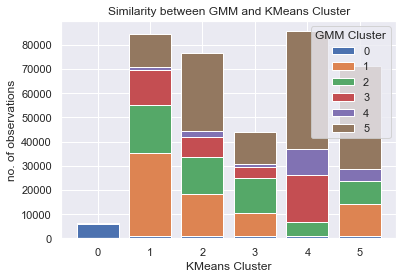

In [22]:
# Define Data

Class = range(len(trip_data["labels"].unique()))

# Define width of stacked chart

w = 0.8

# Plot stacked bar chart

plt.bar(Class, dfPlot[0], w)
plt.bar(Class, dfPlot[1], w, bottom=dfPlot[0])
plt.bar(Class, dfPlot[2], w, bottom=dfPlot[0]+dfPlot[1])
plt.bar(Class, dfPlot[3], w, bottom=dfPlot[0]+dfPlot[1]+dfPlot[2])
plt.bar(Class, dfPlot[4], w, bottom=dfPlot[0]+dfPlot[1]+dfPlot[2]+dfPlot[3])
plt.bar(Class, dfPlot[5], w, bottom=dfPlot[0] + dfPlot[1]+dfPlot[2]+dfPlot[3]+dfPlot[4])

plt.title("Similarity between GMM and KMeans Cluster")
plt.legend(Class, title="GMM Cluster")
plt.xlabel("KMeans Cluster")
plt.ylabel("no. of observations")
plt.show()


### KMeans Cluster description


Cluster 5: very long duration trips ( >150 hours)

In [23]:
trip_data[trip_data["KM_labels"] == 0].describe()


start_lng    start_lat      end_lng      end_lat     distance  \
count  6399.000000  6399.000000  6399.000000  6399.000000  6399.000000   
mean     13.745897    51.049405    13.744184    51.049489     1.660258   
std       0.029894     0.015870     0.028507     0.015926     2.021693   
min      13.474286    50.932640    13.472892    50.855493     0.000000   
25%      13.730577    51.038466    13.729830    51.038466     0.134878   
50%      13.741220    51.048989    13.741118    51.049181     1.025950   
75%      13.757055    51.059901    13.753959    51.060231     2.526005   
max      13.948932    51.168831    14.094998    51.164453    30.527313   

             month      weekday    dayofyear     duration  temperature  \
count  6399.000000  6399.000000  6399.000000  6399.000000  6399.000000   
mean      6.402563     3.216128   180.295046   315.895296    16.684004   
std       2.607639     2.007103    79.877081   105.795214     8.429947   
min       1.000000     0.000000     1.000000   148.000000    -8.980000   
25%       5.000000     1.000000   125.000000   234.000000    10.333333   
50%       7.000000     3.000000   186.000000   295.000000    18.040000   
75%       8.000000     5.000000   216.000000   389.000000    22.647727   
max      12.000000     6.000000   365.000000   600.000000    36.950000   

              wind         rain          sun   start_hour  label_probability  \
count  6399.000000  6399.000000  6399.000000  6399.000000        6399.000000   
mean      4.153388     0.040939    26.052433     9.053446           0.992962   
std       1.903820     0.205855    22.478583     4.987821           0.018184   
min       0.800000     0.000000     0.000000     0.000000           0.900230   
25%       2.750000     0.000000     1.937500     6.000000           0.999277   
50%       3.825000     0.000000    22.600000     9.000000           1.000000   
75%       5.122222     0.000000    48.333333    13.000000           1.000000   
max      15.580000     3.620000    60.000000    21.000000           1.000000   

            labels  KM_labels  
count  6399.000000     6399.0  
mean      0.182841        0.0  
std       0.576457        0.0  
min       0.000000        0.0  
25%       0.000000        0.0  
50%       0.000000        0.0  
75%       0.000000        0.0  
max       2.000000        0.0

In [24]:
trip_data[trip_data["KM_labels"] != 0].describe()


start_lng      start_lat        end_lng        end_lat  \
count  361820.000000  361820.000000  361820.000000  361820.000000   
mean       13.741154      51.047503      13.741111      51.047489   
std         0.024039       0.014661       0.024496       0.014688   
min        13.470018      50.895396      13.469790      50.796044   
25%        13.728738      51.034742      13.728238      51.034860   
50%        13.738849      51.046507      13.738554      51.046490   
75%        13.751290      51.058147      13.751290      51.058110   
max        14.147443      51.168360      14.143452      51.350596   

            distance          month        weekday      dayofyear  \
count  361820.000000  361820.000000  361820.000000  361820.000000   
mean        1.508762       6.782820       2.877533     190.726322   
std         1.346979       3.083142       1.926701      93.910143   
min         0.000000       1.000000       0.000000       1.000000   
25%         0.543979       4.000000       1.000000     119.000000   
50%         1.187444       7.000000       3.000000     186.000000   
75%         2.184150       9.000000       4.000000     269.000000   
max        36.270746      12.000000       6.000000     365.000000   

            duration    temperature           wind           rain  \
count  361820.000000  361820.000000  361820.000000  361820.000000   
mean       17.721928      13.745657       4.181298       0.049654   
std        20.920940       7.534107       2.111470       0.392925   
min         2.000000      -9.400000       0.200000       0.000000   
25%         7.000000       7.650000       2.650000       0.000000   
50%        11.000000      14.050000       3.850000       0.000000   
75%        20.000000      19.250000       5.300000       0.000000   
max       362.000000      38.000000      18.800000      18.100000   

                 sun     start_hour  label_probability         labels  \
count  361820.000000  361820.000000      361820.000000  361820.000000   
mean       19.136664      13.296263           0.988238       3.258734   
std        24.239465       5.605809           0.020422       1.666128   
min         0.000000       0.000000           0.900008       0.000000   
25%         0.000000       9.000000           0.988053       2.000000   
50%         0.500000      14.000000           0.997506       3.000000   
75%        44.000000      18.000000           0.999613       5.000000   
max        60.000000      23.000000           1.000000       5.000000   

           KM_labels  
count  361820.000000  
mean        2.951683  
std         1.472432  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         4.000000  
max         5.000000

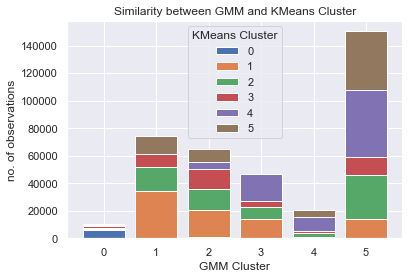

In [25]:
# Define Data

Class = range(len(trip_data["labels"].unique()))
# Define width of stacked chart

w = 0.8

# Plot stacked bar chart

plt.bar(Class, dfPlot.loc[0], w)
plt.bar(Class, dfPlot.loc[1], w, bottom=dfPlot.loc[0])
plt.bar(Class, dfPlot.loc[2], w, bottom=dfPlot.loc[0]+dfPlot.loc[1])
plt.bar(Class, dfPlot.loc[3], w,
        bottom=dfPlot.loc[0]+dfPlot.loc[1]+dfPlot.loc[2])
plt.bar(Class, dfPlot.loc[4], w, bottom=dfPlot.loc[0] +
        dfPlot.loc[1]+dfPlot.loc[2]+dfPlot.loc[3])
plt.bar(Class, dfPlot.loc[5], w, bottom=dfPlot.loc[0] +
        dfPlot.loc[1]+dfPlot.loc[2]+dfPlot.loc[3]+dfPlot.loc[4])

plt.title("Similarity between GMM and KMeans Cluster")
plt.legend(Class, title="KMeans Cluster")
plt.xlabel("GMM Cluster")
plt.ylabel("no. of observations")
plt.show()


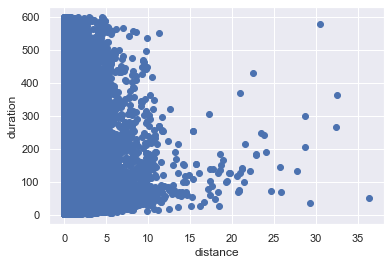

In [26]:
plt.scatter(trip_data["distance"], trip_data["duration"])
plt.xlabel("distance")
plt.ylabel("duration")
plt.show()
